In [68]:
%load_ext autoreload
%autoreload 2

import matplotlib 
from matplotlib import pyplot as plt
from sklearn.datasets import make_moons
import torch
from torch import nn
from torch.optim import Adam
import numpy as np
from tqdm import tqdm

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [101]:
def test_bijective_tr(sample_data, infer, generate):
    fig, axes = plt.subplots(1, 4, figsize=(17, 4))

    axes[0].scatter(sample_data[:, 0], sample_data[:, 1], s=0.2)
    axes[0].set_title('$X \sim p(X)$')

    zs = infer(torch.FloatTensor(sample_data)).detach().numpy()
    axes[1].scatter(zs[:, 0], zs[:, 1], s=0.2)
    axes[1].set_title('$\hat{Z} \leftarrow f(X)$')

    norm = torch.distributions.Normal(torch.zeros(2), torch.ones(2))
    zs_sampled = norm.sample((len(sample_data),))

    axes[2].scatter(zs_sampled[:, 0], zs_sampled[:, 1], s=0.2)
    axes[2].set_title('$Z \sim \mathcal{N}(\cdot|\mathbf{0}, \mathbf{1})$')

    gx = generate(torch.FloatTensor(zs_sampled)).detach().numpy()
    axes[3].scatter(gx[:, 0], gx[:, 1], s=0.2)
    axes[3].set_title('$\hat{X} \leftarrow f^{-1}(Z)$')

In [103]:
from agents.lsp_hierarchical_rl.model import BijectiveTransform
f = BijectiveTransform(
    2, 6, scale_net_hidden_layer_num=2, scale_net_hidden_layer_size=256, 
    translate_net_hidden_layer_num=2, translate_net_hidden_layer_size=256,
    condition_vector_size=0)
optim = Adam(f.parameters())

TRAIN_EPOCHS = 5001
BATCH_SIZE = 200
pbar = tqdm(range(TRAIN_EPOCHS))
condition_zero, condition_one = torch.FloatTensor([0.]), torch.FloatTensor([1.])
for epoch in pbar:
    xs, ys = make_moons(BATCH_SIZE, noise=0.05)
    xs = xs[ys == 0]

    ll = f.calc_log_likelihood(torch.FloatTensor(xs))
    optim.zero_grad()
    (-ll).backward()
    optim.step()

    if epoch % 1000 == 0:
        print("EPOCH {} --- Log-likelihood {:.2f}".format(epoch, ll.item()))


  0%|          | 6/5001 [00:00<04:15, 19.52it/s]

EPOCH 0 --- Log-likelihood -2.31


 10%|█         | 505/5001 [00:15<02:03, 36.39it/s]

EPOCH 500 --- Log-likelihood 0.17


 20%|██        | 1005/5001 [00:32<02:37, 25.41it/s]

EPOCH 1000 --- Log-likelihood 0.31


 30%|███       | 1506/5001 [00:51<02:11, 26.58it/s]

EPOCH 1500 --- Log-likelihood 0.18


 40%|████      | 2004/5001 [01:09<01:53, 26.44it/s]

EPOCH 2000 --- Log-likelihood 0.33


 50%|█████     | 2505/5001 [01:28<01:32, 26.91it/s]

EPOCH 2500 --- Log-likelihood 0.33


 60%|██████    | 3006/5001 [01:47<01:19, 25.06it/s]

EPOCH 3000 --- Log-likelihood 0.33


 70%|███████   | 3504/5001 [02:06<00:59, 25.27it/s]

EPOCH 3500 --- Log-likelihood 0.35


 80%|████████  | 4005/5001 [02:26<00:38, 26.10it/s]

EPOCH 4000 --- Log-likelihood 0.42


 90%|█████████ | 4506/5001 [02:45<00:18, 26.20it/s]

EPOCH 4500 --- Log-likelihood 0.38


100%|██████████| 5001/5001 [03:04<00:00, 27.12it/s]

EPOCH 5000 --- Log-likelihood 0.48


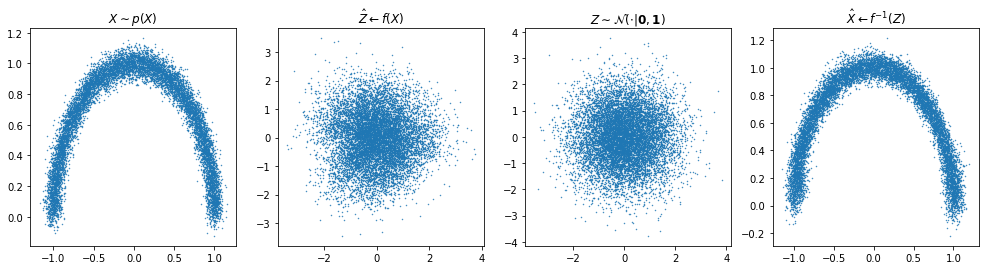

In [104]:
xs, ys = make_moons(2*N, noise=0.05)
xs = xs[ys==0]
test_bijective_tr(xs, lambda x: f.infer(x)[0], lambda x: f.generate(x)[0])

In [129]:
from agents.lsp_hierarchical_rl.model import BijectiveTransform
f = BijectiveTransform(
    2, 6, scale_net_hidden_layer_num=2, scale_net_hidden_layer_size=256, 
    translate_net_hidden_layer_num=2, translate_net_hidden_layer_size=256,
    condition_vector_size=1)
optim = Adam(f.parameters())

TRAIN_EPOCHS = 5001
BATCH_SIZE = 100
pbar = tqdm(range(TRAIN_EPOCHS))

for epoch in pbar:
    xs, ys = make_moons(BATCH_SIZE * 2, noise=0.05)
    xs0 = xs[ys==0]
    xs1 = xs[ys==1]
        
    ll_0 = f.calc_log_likelihood(torch.FloatTensor(xs0), torch.zeros(len(xs0), 1))
    ll_1 = f.calc_log_likelihood(torch.FloatTensor(xs1), torch.ones(len(xs0), 1))
    ll = ll_0 + ll_1
    optim.zero_grad()
    (-ll).backward()
    optim.step()

    if epoch % 1000 == 0:
        print("EPOCH {} --- Log-likelihood {:.2f}".format(epoch, ll.item()))

  0%|          | 4/5001 [00:00<04:56, 16.84it/s]

EPOCH 0 --- Log-likelihood -5.11


 20%|██        | 1003/5001 [00:58<04:02, 16.47it/s]

EPOCH 1000 --- Log-likelihood 0.42


 40%|████      | 2003/5001 [02:01<03:13, 15.53it/s]

EPOCH 2000 --- Log-likelihood 0.80


 60%|██████    | 3003/5001 [03:05<02:11, 15.14it/s]

EPOCH 3000 --- Log-likelihood 0.79


 80%|████████  | 4003/5001 [04:09<01:21, 12.27it/s]

EPOCH 4000 --- Log-likelihood 0.58


100%|██████████| 5001/5001 [05:11<00:00, 16.04it/s]

EPOCH 5000 --- Log-likelihood 0.65


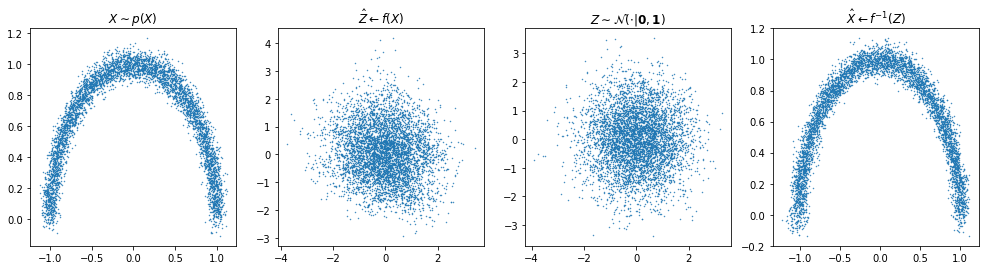

In [139]:
xs, ys = make_moons(10000, noise=0.05)
xs = xs[ys==0]
test_bijective_tr(xs, lambda x: f.infer(x, torch.zeros((len(x), 1)))[0], lambda x: f.generate(x, torch.zeros((len(x), 1)))[0])

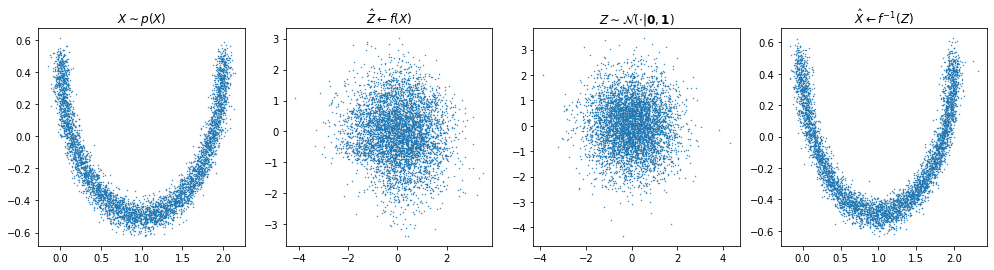

In [140]:
xs, ys = make_moons(10000, noise=0.05)
xs = xs[ys==1]
test_bijective_tr(xs, lambda x: f.infer(x, torch.ones((len(x), 1)))[0], lambda x: f.generate(x, torch.ones((len(x), 1)))[0])

Text(0.5, 1.0, '$\\hat{X} \\leftarrow f^{-1}(Z)$')

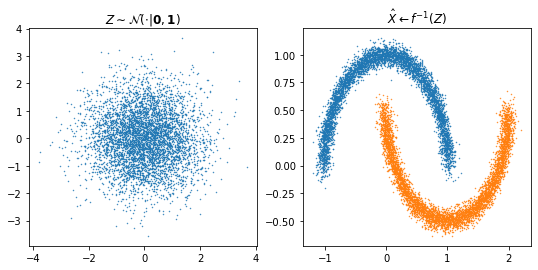

In [138]:
fig, axes = plt.subplots(1, 2, figsize=(9, 4))

norm = torch.distributions.Normal(torch.zeros(2), torch.ones(2))
zs_sampled = norm.sample((5000,))

axes[0].scatter(zs_sampled[:, 0], zs_sampled[:, 1], s=0.2)
axes[0].set_title('$Z \sim \mathcal{N}(\cdot|\mathbf{0}, \mathbf{1})$')

gx0 = f.generate(torch.FloatTensor(zs_sampled), torch.zeros(len(zs_sampled), 1))[0].detach().numpy()
gx1 = f.generate(torch.FloatTensor(zs_sampled), torch.ones(len(zs_sampled), 1))[0].detach().numpy()
axes[1].scatter(gx0[:, 0], gx0[:, 1], s=0.2)
axes[1].scatter(gx1[:, 0], gx1[:, 1], s=0.2)
axes[1].set_title('$\hat{X} \leftarrow f^{-1}(Z)$')